In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.ticker as mtick

import s3fs
import os
import torch
import random
import json
import boto
# import sktime

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from redshift import get_from_redshift
from datetime import datetime
from config import Config  
from collections import defaultdict, Counter
from tqdm import tqdm 
from itertools import zip_longest

tqdm.pandas()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Loading data

In [2]:
%%writefile isco08.sql
SELECT * FROM dev.intermediate.isco08_unit_group

Overwriting isco08.sql


In [3]:
get_from_redshift("isco08.sql", Config.redshift_creds)

,repository_timestamp,code_isco08_unitgroup,omschrijving_isco08_unitgroup,batchid,batch_ts
0,2018-03-01 07:45:31.903342,2621,Archivists and curators,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
1,2018-03-01 07:45:31.903342,3352,Government tax and excise officials,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
2,2018-03-01 07:45:31.903342,8331,Bus and tram drivers,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
3,2018-03-01 07:45:31.903342,1330,Information and communications technology serv...,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
4,2018-03-01 07:45:31.903342,4321,Stock clerks,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
...,...,...,...,...,...
431,2018-03-01 07:45:31.903342,1213,Policy and planning managers,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
432,2018-03-01 07:45:31.903342,7212,Welders and flamecutters,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
433,2018-03-01 07:45:31.903342,7112,Bricklayers and related workers,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604
434,2018-03-01 07:45:31.903342,3252,Medical records and health information technic...,3ebd0872-5648-421e-a9d3-fdbd0f4ec498,2017-07-14 11:15:50.626604


### Work experience

In [2]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_work_experience) 

In [3]:
candidate_work_experience = get_from_redshift(sql_path, Config.redshift_creds)
candidate_work_experience.head()

,candidate_id,unique_id,date_start_job,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source
0,85712,8739639,2017-12-14 00:00:00,2018-08-01,2338.0,2.0,4321.0,None,Tapfin inz UPS SP (HFD),plaatsing
1,85712,8777822,2018-01-22 00:00:00,2018-01-24,2038.0,1.0,9329.0,None,Arvato Benelux BV,plaatsing
2,85712,9977222,2020-07-27 00:00:00,2020-12-14,2038.0,1.0,9329.0,None,Koninklijke de Ruyter B.V.,plaatsing
3,85712,9981694,2020-08-02 00:00:00,2020-08-10,2038.0,1.0,9329.0,Productiemedewerker,Grozette BV,plaatsing
4,85888,15682354,2009-02-01 00:00:00,2011-02-01,NaN,NaN,NaN,beheerder,eurest catering,dossier


### Education

In [5]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_education) 

In [6]:
candidate_education = get_from_redshift(sql_path, Config.redshift_creds)
candidate_education.head()

,candidate_id,education_level,date_start,date_end,date_registrated,passed
0,311285,2,1980-09-01 00:00:00,1985-07-01 00:00:00,2005-08-17 14:11:21,1
1,96722,4,1992-04-25 00:00:00,1994-04-25 00:00:00,2005-07-26 17:14:33,0
2,382387,3,1974-09-01 00:00:00,1980-09-01 00:00:00,2005-08-30 11:23:41,1
3,283389,2,1995-08-01 00:00:00,1999-07-01 00:00:00,2005-08-16 19:05:46,1
4,296299,3,1995-09-01 00:00:00,1996-01-01 00:00:00,2005-08-17 13:15:27,0


### Skills

In [7]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_skills) 

#### What's date start here? 

In [8]:
candidate_skill = get_from_redshift(sql_path, Config.redshift_creds)
candidate_skill.head()

,candidate_id,skill_id,date_start
0,6512520,2955,2016-05-11 21:04:59
1,6607639,62,2016-06-09 21:06:59
2,6194968,3070,2016-07-07 14:37:39
3,6551886,63,2016-03-10 11:59:19
4,6476281,52,2016-07-29 04:01:56


### Languages

In [9]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_languages) 

In [10]:
candidate_languages = get_from_redshift(sql_path, Config.redshift_creds)
candidate_languages.head()

,candidate_id,language_id,date_start
0,1825327,40,2010-03-09 18:37:46
1,104849,17,2010-03-09 18:38:13
2,716267,40,2010-03-09 18:38:21
3,1954085,15,2010-03-09 18:38:39
4,2270512,40,2010-03-09 18:38:44


In [11]:
lang_to_idx = {v : i for i, v in enumerate(sorted(candidate_languages["language_id"].astype(float).unique()))}
idx_to_lang = {v : i for i, v in lang_to_idx.items()}
candidate_languages["language_id"] = candidate_languages["language_id"].progress_apply(lambda x: lang_to_idx[x])

100%|██████████| 2111821/2111821 [00:03<00:00, 581683.54it/s]


In [12]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_mapping_languages) 

In [13]:
language_mappings = get_from_redshift(sql_path, Config.redshift_creds)
language_mappings.head()

,language_id,language
0,302,Fries
1,50,Russisch
2,48,Portugees
3,296,Zweeds
4,317,Pools


In [14]:
language_mapper = language_mappings.set_index("language_id").to_dict()["language"]

In [15]:
index_to_language = {k: language_mapper[v] for k, v in idx_to_lang.items()}

In [16]:
candidate_languages["language_id"] = candidate_languages["language_id"].apply(lambda x: index_to_language[x])

In [17]:
candidate_languages.drop("date_start", axis=1).to_csv("../Data/languages_mappings.csv")

In [18]:
languages_oh = pd.crosstab(candidate_languages["candidate_id"],
                           candidate_languages["language_id"])

In [19]:
languages_oh.head()

language_id,Arabisch,Berber,Chinees,Deens,Duits,Engels,Fins,Frans,Fries,Hongaars,...,Nederlands,Noors,Pools,Portugees,Roemeens,Russisch,Spaans,Tjechisch/Slowaaks,Turks,Zweeds
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
84386,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
languages_oh.to_csv("../Data/languages_mappings.csv")

### Addresses

In [20]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_addresses) 

In [21]:
candidate_addresses = get_from_redshift(sql_path, Config.redshift_creds)
candidate_addresses.head()

,candidate_id,from_post_code,date_start,date_end
0,5342653,3061 MH,2015-03-11 00:00:00,None
1,8544570,9302 CB,2021-05-10 00:00:00,None
2,3350344,7051 WR,2017-05-01 00:00:00,None
3,6608738,5142 SK,2016-05-03 00:00:00,None
4,7230607,6811 HA,2017-11-15 00:00:00,None


In [22]:
candidate_addresses.shape

(4189848, 4)

In [23]:
# Drop nonsense rows
candidate_addresses = candidate_addresses[(candidate_addresses["date_start"] >= dt.datetime(1950, 1, 1)) &
                                          (candidate_addresses["date_start"] <= dt.datetime(2025, 1, 1))]

In [24]:
candidate_addresses.shape

(4189697, 4)

In [25]:
# Only store for candidates we will actually be using
candidate_addresses = candidate_addresses[candidate_addresses["candidate_id"].isin(
    set(candidate_work_experience["candidate_id"].unique()))]

In [26]:
candidate_addresses.shape

(773365, 4)

In [27]:
most_recent_address = candidate_addresses.groupby("candidate_id")["date_start"].progress_apply(max)

100%|██████████| 528830/528830 [02:23<00:00, 3696.41it/s]


In [28]:
# TODO: do this in a way that isn't hideous
makeshift_index = set((most_recent_address.index.astype(str) + most_recent_address.astype(str)).values)

In [29]:
candidate_addresses.loc[:,"temp"] = candidate_addresses["candidate_id"].astype(str) + candidate_addresses["date_start"].astype(str)

In [30]:
candidate_addresses = candidate_addresses[candidate_addresses["temp"].isin(makeshift_index)].drop("temp", axis=1)

In [31]:
candidate_addresses["from_post_code"] = candidate_addresses["from_post_code"].str.slice(0, 4)

In [32]:
candidate_final_addresses = candidate_addresses.groupby("candidate_id")["from_post_code"].progress_apply(lambda x: x.values[-1])

100%|██████████| 528830/528830 [00:16<00:00, 32504.39it/s]


In [35]:
candidate_final_addresses.to_csv("../Data/address_mappings.csv")

In [33]:
zip_to_idx = {v : i for i, v in enumerate(sorted(candidate_final_addresses.unique()))}
idx_to_zip = {v : i for i, v in zip_to_idx.items()}
candidate_final_addresses = candidate_final_addresses.progress_apply(lambda x: zip_to_idx[x])

100%|██████████| 528830/528830 [00:00<00:00, 534803.06it/s]


In [37]:
with open("../Data/index_to_zip_code.json", "w") as outfile:
    json.dump(idx_to_zip, outfile) 

In [34]:
addresses_one_hot = pd.get_dummies(candidate_final_addresses)

addresses_one_hot.head()

,0,1,2,3,4,5,6,7,8,9,...,4754,4755,4756,4757,4758,4759,4760,4761,4762,4763
candidate_id,,,,,,,,,,,,,,,,,,,,,
84556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# DIY Sparse matrix
compressed_addresses_one_hot = addresses_one_hot.idxmax(axis=1)

In [40]:
compressed_addresses_one_hot.to_csv("../Data/addresses_one-hot.csv")

### Driving licenses

In [36]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_driving_license) 

In [37]:
candidate_driving = get_from_redshift(sql_path, Config.redshift_creds)
candidate_driving.head()

,candidate_id,driving_licenses,date_driving_license
0,394917,A,2012-02-15 15:10:09
1,540763,A,2015-09-15 14:54:36
2,765059,A,2013-10-30 12:46:24
3,600764,A,2005-09-20 14:27:04
4,219412,A,2014-10-01 14:19:30


In [38]:
candidate_driving = candidate_driving[candidate_driving["candidate_id"].isin(set(candidate_work_experience["candidate_id"].unique()))]

In [39]:
candidate_driving[["candidate_id", "driving_licenses"]].set_index("candidate_id").to_csv("../Data/license_mappings.csv")

In [40]:
licenses_one_hot = pd.crosstab(candidate_driving["candidate_id"],
                               candidate_driving["driving_licenses"])

In [41]:
licenses_one_hot.shape

(212822, 8)

In [47]:
licenses_one_hot.to_csv("../Data/licenses_one-hot.csv")

# Skill reindexing

In [42]:
skill_to_idx = {v : i for i, v in enumerate(sorted(candidate_skill["skill_id"].astype(float).unique()))}
idx_to_skill = {v : i for i, v in skill_to_idx.items()}
candidate_skill["skill_id"] = candidate_skill["skill_id"].progress_apply(lambda x: skill_to_idx[x])
skills_dict = candidate_skill.groupby("candidate_id")["skill_id"].apply(list).to_dict()

100%|██████████| 4190460/4190460 [00:07<00:00, 590149.76it/s]


In [43]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_skills_mapping) 
skill_mappings = get_from_redshift(sql_path, Config.redshift_creds)
skill_mappings.head()

,skill_id,skill_name,vce_id
0,28,Kassa bediening,4
1,49,Presentatieprogramma's,15
2,2997,C: Programmeertalen,7
3,2947,mySQL: Beheer databases,7
4,3928,RUP,7


In [44]:
skill_mappings = skill_mappings.set_index("skill_id")["skill_name"].to_dict()

In [45]:
index_to_skill = {k: skill_mappings[v] for k, v in idx_to_skill.items()}

In [46]:
candidate_skill["skill_id"] = candidate_skill["skill_id"].apply(lambda x: index_to_skill[x])

In [53]:
candidate_skill.to_csv("../Data/candidate_skills_mapped.csv")

In [47]:
# Convert lists of skills to dataframe of skills per candidate
skills_ct = pd.crosstab(candidate_skill["candidate_id"], 
                        candidate_skill["skill_id"])

# # skills = skills_ct.where(skills_ct != 1, skills_ct.columns.to_series(), axis=1)
skills_ct.columns = [f"skill_{i}" for i in skills_ct.columns]

In [48]:
skills_ct.head()

,skill_.NET: Kennis programmeertalen,skill_AS/400: Kennis besturingssystemen,skill_Aan telefoon gegevens invoeren,skill_Aan- en uitkleden: Ondersteunen ADL verrichtingen,skill_Aanpassingsvermogen,skill_Administreren,skill_Adobe Illustrator,skill_Adobe Photoshop,skill_Afbramen: Metaal bewerken,skill_Afrekenen,...,skill_Windows 2008 Server: Besturingssystemen,skill_Windows NT server: Netwerken,skill_Windows Vista: Besturingssystemen,skill_Windows XP: Besturingssystemen,skill_Wipcar: Goederenvervoer,skill_XML: Programmeertalen,skill_Zagen: Metaal bewerken,skill_Zelfstandigheid,skill_Ziekte- en verlofadministratie: Administreren,skill_mySQL: Beheer databases
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# skills_ct.to_csv("skills_one-hot.csv")

# Merging and formatting

In [49]:
def clean_df(df, table = "work_experience"):
    
    if table == "work_experience":
        start, end = "date_start_job", "date_end_job"
    elif table == "education":
        start, end = "date_start", "date_end"
    else:
        return NotImplemented
    
    # Drop nonsense data
    df = df[df[start] >= dt.datetime(1800, 1, 1)]
    df = df[df[end] <= dt.datetime(2100, 1, 1)]

    # Convert datetime to date
    df[start] = pd.to_datetime(df[start]).dt.date
    df[end] = pd.to_datetime(df[end]).dt.date
    
    return df
        
candidate_work_experience = clean_df(candidate_work_experience)
candidate_education = clean_df(candidate_education, table = "education")

In [50]:
candidate_work_experience["time_spent"] = (candidate_work_experience["date_end_job"] - 
                                           candidate_work_experience["date_start_job"]).dt.days.astype('int16')

In [51]:
def find_educations(df_work, df_education):

    # Merge career data with education levels
    career_education = pd.merge(df_work, 
                                df_education, 
                                on = "candidate_id", 
                                how = "left")[["candidate_id",
                                               "date_start_job",
                                               "date_end_job",
                                               "company_name",
                                               "time_spent",
                                               "source",
                                               "education_level",
                                               "date_start",
                                               "date_end",
                                               "passed"]]
    
    # Filter out education that were not passed (yet) at the time of starting a job
    passed = career_education[(career_education["date_start_job"] >= career_education["date_end"]) & 
                              (career_education["passed"] == 1)]
    
    # Only store the highest education level reached at the start of each job
    education_through_time = passed.groupby(["candidate_id", "date_start_job"])["education_level"].max()
    
    df_work.set_index(["candidate_id", "date_start_job"], inplace=True)

    # Store education data in candidate_work_experience
    df_work["education"] = education_through_time

    # np.nan education = no education
    df_work["education"].fillna(0, inplace=True)

    # Reset index for further data augmentation
    df_work.reset_index(inplace=True)
        
    return df_work

candidate_work_experience = find_educations(candidate_work_experience, candidate_education)

candidate_work_experience.head()

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,time_spent,education
0,85712,2017-12-14,8739639,2018-08-01,2338.0,2.0,4321.0,None,Tapfin inz UPS SP (HFD),plaatsing,230,0.0
1,85712,2018-01-22,8777822,2018-01-24,2038.0,1.0,9329.0,None,Arvato Benelux BV,plaatsing,2,0.0
2,85712,2020-07-27,9977222,2020-12-14,2038.0,1.0,9329.0,None,Koninklijke de Ruyter B.V.,plaatsing,140,0.0
3,85712,2020-08-02,9981694,2020-08-10,2038.0,1.0,9329.0,Productiemedewerker,Grozette BV,plaatsing,8,0.0
4,85888,2009-02-01,15682354,2011-02-01,NaN,NaN,NaN,beheerder,eurest catering,dossier,730,3.0


In [52]:
companies = dict(zip(set(candidate_work_experience["company_name"].values), range(len(candidate_work_experience["company_name"].unique()))))

In [53]:
candidate_work_experience["company_name"] = candidate_work_experience["company_name"].apply(lambda x: companies[x])

In [54]:
candidate_work_experience[candidate_work_experience["candidate_id"] == 8468794]

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,time_spent,education
1703448,8468794,2004-04-01,17442359,2008-07-01,1874.0,3.0,3221.0,Verzorgende,58698,dossier,1552,0.0
1703449,8468794,2008-07-01,17442361,2011-06-01,102626.0,3.0,3221.0,Verzorgende IG,58698,dossier,1065,0.0
1703450,8468794,2011-06-01,17442362,2020-09-01,102626.0,3.0,3221.0,Verzorgende IG,259809,dossier,3380,3.0
1703451,8468794,2021-03-08,10161024,2021-10-10,716.0,3.0,3256.0,Prikker/Voorbereider (senior),215946,plaatsing,216,3.0
1703452,8468794,2021-06-14,10314058,2021-10-10,1858.0,3.0,3221.0,None,215946,plaatsing,118,3.0
1703453,8468794,2021-11-23,10439406,2022-02-22,716.0,3.0,3256.0,Prikker/Voorbereider (senior),215946,plaatsing,91,3.0
1703454,8468794,2021-11-23,10439401,2022-03-01,1858.0,3.0,3221.0,Verpleegkundige (senior),215946,plaatsing,98,3.0


In [63]:
index_to_company = {v: k for k, v in companies.items()}

with open("../Data/index_to_company.json", "w") as outfile:
    json.dump(index_to_company, outfile) 

In [55]:
candidate_work_experience["source"] = candidate_work_experience["source"].apply(lambda x: {"plaatsing": 0, "dossier": 1}[x])

In [56]:
# Add skills
# candidate_work_experience = pd.merge(candidate_work_experience, 
#                                      skills_ct, 
#                                      left_on="candidate_id", 
#                                      right_index=True, 
#                                      how="left")

# Filtering and reindexing

In [57]:
more_than_5 = candidate_work_experience["isco_code4"].value_counts()
more_than_5 = set(more_than_5[more_than_5 > 5].index)
candidate_work_experience = candidate_work_experience[candidate_work_experience["isco_code4"].isin(more_than_5)]

In [58]:
id_to_idx = {v : i for i, v in enumerate(sorted(candidate_work_experience["function_id"].astype(float).unique()))}
idx_to_id = {v : i for i, v in id_to_idx.items()}

code_to_idx = {v : i for i, v in enumerate(sorted(candidate_work_experience["isco_code4"].astype(float).unique()))}
idx_to_code = {v : i for i, v in code_to_idx.items()}

In [68]:
with open("../Data/index_to_isco.json", "w") as outfile:
    json.dump(idx_to_code, outfile) 

In [59]:
candidate_work_experience["function_id"] = candidate_work_experience["function_id"].apply(lambda x: id_to_idx.get(x))
candidate_work_experience["isco_code4"] = candidate_work_experience["isco_code4"].apply(lambda x: code_to_idx[x])

In [60]:
candidate_work_experience.head()

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,time_spent,education
0,85712,2017-12-14,8739639,2018-08-01,1757,2.0,195,None,269318,0,230,0.0
1,85712,2018-01-22,8777822,2018-01-24,1518,1.0,344,None,68615,0,2,0.0
2,85712,2020-07-27,9977222,2020-12-14,1518,1.0,344,None,353074,0,140,0.0
3,85712,2020-08-02,9981694,2020-08-10,1518,1.0,344,Productiemedewerker,142084,0,8,0.0
5,85888,2011-05-11,5797421,2011-07-31,796,2.0,229,Catering medewerker,294126,0,81,3.0


In [131]:
len(candidate_work_experience)

1664565

In [94]:
sns.set_style("white")

In [294]:
candidate_work_experience["education"].value_counts().sort_values(ascending=False).reset_index().drop("index", axis=1).sum()

education    1664565
dtype: int64

In [142]:
eds = candidate_work_experience["education"].value_counts().sort_values(ascending=False).reset_index().drop("index", axis=1)
eds /= eds.sum()
eds *= 100

eds.index = ["Not specified", "Primary school", "Secondary school", "MBO", "HBO", "University"]
eds

,education
Not specified,56.816766
Primary school,24.638089
Secondary school,8.611559
MBO,6.772220
HBO,2.479567
University,0.681800


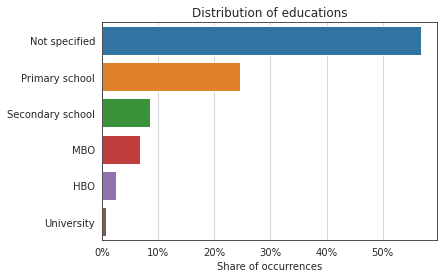

In [143]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot total attention for each feature
sns.barplot(x=eds.T.values[0], y=eds.index)
# ax1.set_xticklabels(labels=series.values, rotation=90)
plt.xlabel("Share of occurrences")
plt.title("Distribution of educations")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.grid(axis='x')
ax.set_axisbelow(True)

# fig.savefig(f"education_dist.pdf", bbox_inches='tight');

In [292]:
eds

,education
Not specified,56.816766
Primary school,24.638089
Secondary school,8.611559
MBO,6.772220
HBO,2.479567
University,0.681800


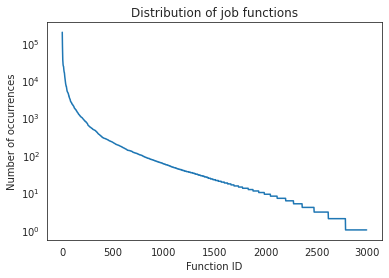

In [290]:
candidate_work_experience["function_id"].value_counts().sort_values(ascending=False).reset_index().drop("index", axis=1).plot(logy=True, legend=None)
plt.title("Distribution of job functions");
plt.xlabel("Function ID");
plt.ylabel("Number of occurrences");

plt.savefig("function_dist.pdf", bbox_inches="tight");

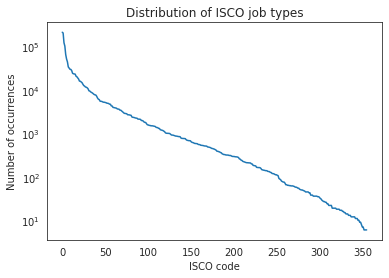

In [128]:
candidate_work_experience["isco_code4"].value_counts().sort_values(ascending=False).reset_index().drop("index", axis=1).plot(logy=True, legend=None)
plt.title("Distribution of ISCO job types");
plt.xlabel("ISCO code");
plt.ylabel("Number of occurrences");

plt.savefig("isco_dist.pdf", bbox_inches="tight");

# Add CV embeddings

In [ ]:
embedding_pd = pd.read_parquet("s3://s3-nl-prd-semrb-emr/embeddings/doc_embeddings/word2vec/word2vec_doc_embedding.parquet")
embedding_pd['cv_id'] = embedding_pd['cv_id'].astype('int')
embedding_pd.rename(columns={"doc_embedding": "tensor"}, inplace=True)

In [72]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_cvs) 

candidate_cvs = get_from_redshift(sql_path, Config.redshift_creds)

In [73]:
cvs = pd.read_parquet(Config.raw_candidate_parsed_cvs)
cv_ids = pd.read_parquet(Config.raw_candidate_cv_id)

In [74]:
cvs["cv_id"] = cvs["cv_id"].astype(int)
cv_ids["cv_id"] = cv_ids["cv_id"].astype(int)

In [174]:
cv_df = pd.merge(cvs[["cv_id", "text"]], cv_ids[["cv_id", "candidate_id", "date_start"]]).drop("cv_id", axis=1)[["candidate_id", "date_start", "text"]]
cv_df["date_start"] = pd.to_datetime(cv_df["date_start"])

In [181]:
def add_texts(candidate_work_experience, cv_texts):
    
    print("merging...")
    # Add CVs to candidates (includes duplicates)
    full_merge = pd.merge(candidate_work_experience,
                          cv_texts,
                          left_on="candidate_id",
                          right_on="candidate_id",
                          how="left")
                       
    print("Finding maxima...")
            
    # Find the maximum date of uploaded cvs per job (i.e. most recent CV during each job)
    most_recent_cvs = full_merge[(full_merge["date_start_job"]
                                  >= full_merge["date_start"])].groupby("unique_id").progress_apply(lambda group:
                                                                                                    group.nlargest(1, 
                                                                                                                   columns='date_start')).reset_index(level=-1, 
                                                                                                                                                      drop=True)
    
    return most_recent_cvs
    
#     # Some candidates only added CVs after their last job started, so account for that too
#     late_cvs = full_merge[(full_merge["date_start_job"] <= 
#                            full_merge["date_start"])].groupby("unique_id")["date_start"].transform(max).index
    
#     print("Cleaning and combining...")
#     # Filter out everything we already found earlier
#     cvs_combined = set(most_recent_cvs)
    
#     # Now we have all the CVs in one place
#     # cv_idxs = pd.concat([most_recent_cvs, late_cvs])
    
#     # full_merge = full_merge.set_index("unique_id")
    
#     # Combine the two frames to include candidates without any CVs
#     combined = pd.concat([full_merge[full_merge["text"].isna()], 
#                           full_merge.loc[cvs_combined]])
    
#     return combined

cv_texts = add_texts(candidate_work_experience, cv_df) #[["unique_id", "text"]]

merging...
Finding maxima...


100%|██████████| 353702/353702 [31:48<00:00, 185.29it/s] 


In [182]:
cv_texts.head()

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,time_spent,education,date_start,text
unique_id,,,,,,,,,,,,,,
3824366,2975708,2010-09-06,3824366,2010-10-01,1245,1.0,336,schoonmaker,112617,1,25,2.0,2010-04-26 22:19:53,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
3923252,2975708,2010-11-01,3923252,2010-11-30,1245,1.0,336,schoonmaakster,330514,1,29,2.0,2010-04-26 22:19:53,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
4018885,2975708,2010-11-22,4018885,2011-02-11,2538,2.0,209,cateringmedewerker,193825,1,81,2.0,2010-04-26 22:19:53,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
4082571,3405093,2016-09-05,4082571,2019-11-15,1994,2.0,194,Financieel administratief mw,96128,1,1166,0.0,2012-10-31 09:36:34,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
4130366,2198174,2009-12-09,4130366,2011-03-28,2091,3.0,118,operator,418352,1,474,0.0,2009-03-21 00:35:44,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...


In [192]:
added_CVs = pd.merge(candidate_work_experience, cv_texts["text"], left_on="unique_id", right_on="unique_id", how="left")

In [193]:
added_CVs = added_CVs.drop_duplicates()

In [139]:
added_CVs = added_CVs.drop(["date_start_job_y", "date_end_job", "source"], axis=1).sort_values(by=["candidate_id", "date_start_job_x"])

In [197]:
added_CVs = added_CVs.sort_values(by=["candidate_id", "date_start_job"])

In [198]:
added_CVs.to_csv("../Data/df_get_CVs.csv")

In [ ]:
def find_embeddings(embedding_pd, candidate_cvs):
    embedding_pd = embedding_pd.set_index("cv_id")
    
    candidate_cvs = candidate_cvs[["cv_id", "candidate_id", "date_start"]]

    embedding_per_candidate = pd.merge(embedding_pd, 
                                       candidate_cvs, 
                                       left_index=True, 
                                       right_on="cv_id")[["candidate_id", "embedding", "date_start"]]
    
    matches = (set(embedding_per_candidate["candidate_id"]) & set(candidate_work_experience["candidate_id"]))
    
    matched_cvs = embedding_per_candidate[embedding_per_candidate["candidate_id"].isin(matches)]
    matched_cvs["date_start"] = matched_cvs["date_start"].dt.date
    
    last_cv_per_day = matched_cvs.groupby(["candidate_id", "date_start"])["embedding"].apply(lambda x: list(x)[-1])
    
    cv_embeddings = last_cv_per_day.reset_index()
    
    return cv_embeddings

cv_embeddings = find_embeddings(embedding_pd, candidate_cvs)

In [65]:
cv_embeddings.head()

,candidate_id,date_start,embedding
0,84556.0,2020-07-02,"[0.07265971601009369, -0.8582056760787964, -0...."
1,84612.0,2020-05-30,"[0.3474675714969635, -1.0429900884628296, -0.3..."
2,84612.0,2020-06-03,"[0.34068500995635986, -1.0179638862609863, -0...."
3,84731.0,2020-06-03,"[0.12455234676599503, -0.1725415289402008, -0...."
4,85437.0,2020-06-06,"[0.2048000991344452, -0.49068811535835266, -0...."


In [ ]:
def add_embeddings(candidate_work_experience, cv_embeddings):
    
    # Add CVs to candidates (includes duplicates)
    full_merge = pd.merge(candidate_work_experience,
                          cv_embeddings,
                          left_on="candidate_id",
                          right_on="candidate_id",
                          how="left")
    
    # display(full_merge)
    
    # Find the maximum date of uploaded cvs per job (i.e. most recent CV during each job)
    most_recent_cvs = full_merge[(full_merge["date_start_job"]
                                  >= full_merge["date_start"])].groupby(
        "unique_id")["date_start"].idxmax()
    
    # Some candidates only added CVs after their last job started, so account for that too
    late_cvs = full_merge[(full_merge["date_start_job"] <= 
                           full_merge["date_start"])].groupby("unique_id")["date_start"].idxmax()
    
    # Filter out everything we already found earlier
    late_cvs = late_cvs[set(late_cvs.index) - set(most_recent_cvs.index)]
    
    # Now we have all the CVs in one place
    cv_idxs = pd.concat([most_recent_cvs, late_cvs])
    
    # Combine the two frames to include candidates without any CVs
    combined = pd.concat([full_merge[full_merge["embedding"].isna()], 
                          full_merge.loc[cv_idxs.values]])
    
    return combined

candidate_work_experience = add_embeddings(candidate_work_experience, cv_embeddings)

In [ ]:
candidate_work_experience = candidate_work_experience.sort_values(by=["candidate_id", "date_start"])

In [ ]:
candidate_work_experience.head()

In [ ]:
candidate_work_experience.to_csv("df_get.csv")

In [68]:
candidate_work_experience = candidate_work_experience.reset_index().drop("index", axis=1)

# Ordering & Time

In [144]:
def add_order(df):
    
    # Count the number of jobs each candidate has ahd
    job_counts = df.groupby("candidate_id").size()  
    
    # Sort by candidate_id, date_start_job
    sorted_df = df.sort_values(by = ['candidate_id', "date_start_job"])
    
    # Reset index
    sorted_df.reset_index(inplace=True, drop=True)
    
    # Create a list of lists containing the order of each candidates jobs (which came first, second, third, etc.)
    order = [np.arange(count) for count in job_counts.values]
    
    # Flatten list
    order = [item for sublist in order for item in sublist]
    
    # Add order to df
    sorted_df["job_order"] = order
    
    # Set a candidate_id, job_order as the index
    return sorted_df.set_index(["candidate_id", 
                                "job_order"])

df = add_order(candidate_work_experience)

In [146]:
df = df[["date_start_job", "date_end_job", "time_spent", "isco_code4", "function_id",
         "isco_functie_niveau", "company_name", "source", "education", "embedding"]]

df.head(10)

date_start_job date_end_job  time_spent  isco_code4  \
candidate_id job_order                                                       
84556        0             2000-08-01   2001-01-04         156         208   
             1             2000-09-07   2001-01-01         116         348   
             2             2000-09-30   2001-07-02         275         208   
             3             2000-10-23   2000-10-27           4         344   
             4             2003-12-22   2004-01-02          11         344   
             5             2004-07-12   2004-07-13           1         344   
             6             2005-04-11   2005-07-01          81         344   
             7             2005-05-25   2005-06-01           7         344   
             8             2005-07-27   2005-08-26          30         344   
             9             2006-03-16   2006-05-15          60         345   

                        function_id  isco_functie_niveau  company_name  \
candidate_id job_order                                                   
84556        0                  937                  2.0         31320   
             1                  810                  1.0         31320   
             2                  937                  2.0        215514   
             3                 1518                  1.0        104789   
             4                 1518                  1.0        361107   
             5                 1518                  1.0        361107   
             6                 1518                  1.0        327687   
             7                 1518                  1.0         43892   
             8                 1518                  1.0        128467   
             9                  894                  1.0        119188   

                        source  education  
candidate_id job_order                     
84556        0               0        0.0  
             1               0        0.0  
             2               0        0.0  
             3               0        0.0  
             4               0        0.0  
             5               0        0.0  
             6               0        0.0  
             7               0        0.0  
             8               0        0.0  
             9               0        0.0

In [276]:
career_lengths = df.reset_index().groupby("candidate_id").apply(len)

In [277]:
len(career_lengths)

472647

In [278]:
def create_bins(x):
    if 0 <= x <= 1:
        return 1
    elif 1 < x <= 3:
        return 2
    elif 3 < x <= 5:
        return 3
    elif 5 < x <= 10:
        return 4
    elif 10 < x <= 25:
        return 5
    elif x > 25:
        return 6
    

In [279]:
bin_dist = career_lengths.progress_apply(create_bins).value_counts()

100%|██████████| 472647/472647 [00:00<00:00, 711469.03it/s]


In [280]:
bin_dist.index = ["[0, 1]", "(1, 3]", "(3, 5]", "(5, 10]", "(10, 25]", "(25, ∞)"]

In [281]:
bin_dist /= bin_dist.sum()

In [282]:
bin_dist *= 100

In [283]:
bin_dist

[0, 1]      43.543913
(1, 3]      30.331939
(3, 5]      11.229522
(5, 10]      9.460126
(10, 25]     4.439677
(25, ∞)      0.994823
dtype: float64

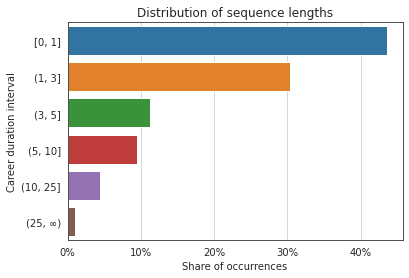

In [291]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot total attention for each feature
sns.barplot(x=bin_dist.T, y=bin_dist.index)
# ax1.set_xticklabels(labels=series.values, rotation=90)
plt.xlabel("Share of occurrences")
plt.ylabel("Career duration interval")
plt.title("Distribution of sequence lengths")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.grid(axis='x')
ax.set_axisbelow(True)
plt.savefig("sequence_dist.pdf", bbox_inches="tight");

In [74]:
def change_steps(df):
    """Groups users' careers by same job types. I.e., if someone didn't
       change the type of job they had, but just the company, it will be
       grouped into one time step."""
    
    new_values = defaultdict(list)
    
    total_time_spent = 0
    education = 0
    date_end_job = dt.date(1970, 1, 1)
    
    for i in tqdm(range(len(df))):
        if i < len(df) - 1:
            current = df.iloc[i]
            next_ = df.iloc[i + 1]
            # Group all consecutive time steps with the same job 
            if (current.name[0] != next_.name[0]) or (current["isco_code4"] != next_["isco_code4"]):
                # Add values of last correct row
                total_time_spent += current["time_spent"]
                if current["education"] > education:
                    education = current["education"]

                if current["date_end_job"] > date_end_job:
                    date_end_job = current["date_end_job"]

                # Store results
                new_values["candidate_id"].append(current.name[0])
                new_values["date_start_job"].append(current["date_start_job"])
                new_values["date_end_job"].append(date_end_job)
                new_values["time_spent"].append(total_time_spent)
                new_values["isco_code4"].append(current["isco_code4"])
                new_values["function_id"].append(current["function_id"])
                new_values["isco_functie_niveau"].append(current["isco_functie_niveau"])
                new_values["education"].append(education)
                new_values["embedding"].append(current["embedding"])

                # Reset values
                total_time_spent = 0
                education = 0
                date_end_job = dt.date(1970, 1, 1)           
            else:
                total_time_spent += current["time_spent"]
                if current["education"] > education:
                    education = current["education"]

                if current["date_end_job"] > date_end_job:
                    date_end_job = current["date_end_job"]

    return pd.DataFrame(new_values)

# df = change_steps(df)

In [75]:
df.head()

date_start_job date_end_job  time_spent  isco_code4  \
candidate_id job_order                                                       
84556        0             2000-08-01   2001-01-04         156         208   
             1             2000-09-07   2001-01-01         116         348   
             2             2000-09-30   2001-07-02         275         208   
             3             2000-10-23   2000-10-27           4         344   
             4             2003-12-22   2004-01-02          11         344   

                        function_id  isco_functie_niveau  company_name  \
candidate_id job_order                                                   
84556        0                  936                  2.0        324258   
             1                  809                  1.0        324258   
             2                  936                  2.0        329244   
             3                 1519                  1.0        368140   
             4                 1519                  1.0        419826   

                        source  education  \
candidate_id job_order                      
84556        0               0        0.0   
             1               0        0.0   
             2               0        0.0   
             3               0        0.0   
             4               0        0.0   

                                                                embedding  
candidate_id job_order                                                     
84556        0          [0.07265971601009369, -0.8582056760787964, -0....  
             1          [0.07265971601009369, -0.8582056760787964, -0....  
             2          [0.07265971601009369, -0.8582056760787964, -0....  
             3          [0.07265971601009369, -0.8582056760787964, -0....  
             4          [0.07265971601009369, -0.8582056760787964, -0....

In [76]:
# Calculate the time it took to go from one job to another (in order)
df["time_between"] = df.groupby(
    "candidate_id")["date_start_job"].progress_apply(lambda x: x - x.shift(1))

100%|██████████| 469568/469568 [07:08<00:00, 1095.55it/s]


In [77]:
df["time_between"] = df["time_between"].shift(-1).fillna(pd.Timedelta(seconds=0)).dt.days.astype('int16')

In [78]:
df.head()

date_start_job date_end_job  time_spent  isco_code4  \
candidate_id job_order                                                       
84556        0             2000-08-01   2001-01-04         156         208   
             1             2000-09-07   2001-01-01         116         348   
             2             2000-09-30   2001-07-02         275         208   
             3             2000-10-23   2000-10-27           4         344   
             4             2003-12-22   2004-01-02          11         344   

                        function_id  isco_functie_niveau  company_name  \
candidate_id job_order                                                   
84556        0                  936                  2.0        324258   
             1                  809                  1.0        324258   
             2                  936                  2.0        329244   
             3                 1519                  1.0        368140   
             4                 1519                  1.0        419826   

                        source  education  \
candidate_id job_order                      
84556        0               0        0.0   
             1               0        0.0   
             2               0        0.0   
             3               0        0.0   
             4               0        0.0   

                                                                embedding  \
candidate_id job_order                                                      
84556        0          [0.07265971601009369, -0.8582056760787964, -0....   
             1          [0.07265971601009369, -0.8582056760787964, -0....   
             2          [0.07265971601009369, -0.8582056760787964, -0....   
             3          [0.07265971601009369, -0.8582056760787964, -0....   
             4          [0.07265971601009369, -0.8582056760787964, -0....   

                        time_between  
candidate_id job_order                
84556        0                    37  
             1                    23  
             2                    23  
             3                  1155  
             4                   203

In [79]:
num_classes = len(df["isco_code4"].unique())

In [81]:
# df_pred = df[["isco_functie_niveau", "education", "function_id"]].fillna(0)
pred_cols = ["time_between", "time_spent", "isco_functie_niveau", 
             "source", "education", "company_name", "function_id", "isco_code4"] # + [col for col in df.columns if "skill_" in col]
num_features = len(pred_cols)

df_pred = df[pred_cols].fillna(0)

In [82]:
df_pred.head()

time_between  time_spent  isco_functie_niveau  source  \
candidate_id job_order                                                          
84556        0                    37         156                  2.0       0   
             1                    23         116                  1.0       0   
             2                    23         275                  2.0       0   
             3                  1155           4                  1.0       0   
             4                   203          11                  1.0       0   

                        education  company_name  function_id  isco_code4  
candidate_id job_order                                                    
84556        0                0.0        324258          936         208  
             1                0.0        324258          809         348  
             2                0.0        329244          936         208  
             3                0.0        368140         1519         344  
             4                0.0        419826         1519         344

In [41]:
df_pred[["function_id", "isco_code4"]].reset_index().to_csv("../Data/DTW_df_pred2.csv")

### Create separate embedding dict

Done for optimization purposes

In [51]:
embedding_order = df.reset_index()[["candidate_id", "embedding"]]

In [52]:
grouped_embeddings = embedding_order.groupby("candidate_id")

In [53]:
embedding_a = defaultdict(lambda: defaultdict(list))

# Find each time step at which the candidate got a new CV
for candidate, values in tqdm(grouped_embeddings):
    embeddings = values["embedding"].values
  
    if (type(embeddings[0]) == type(np.array([]))) and np.nan not in embeddings[0]:
        embedding_a[candidate][0] = embeddings[0]
        
        for i, embedding in enumerate(embeddings):
            if i > 0:
                truths = embeddings[i - 1] != embedding

                if (type(truths) == type(np.array([]))) and (truths).all():
                    embedding_a[candidate][i] = embedding

100%|██████████| 469073/469073 [01:21<00:00, 5736.13it/s]


In [54]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [55]:
with open('../Data/embeddings_grouped.json', 'w') as f:
    json.dump(embedding_a, f, cls=NumpyEncoder)

In [84]:
df_pred.reset_index().to_csv("../Data/df_pred_ext.csv")

In [ ]:
pd.Series(skills_dict).to_csv("../Data/skills.csv")

### Candidate Certificates

In [83]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_certificates) 

candidate_certificates = get_from_redshift(sql_path, Config.redshift_creds)
candidate_certificates.head()

,candidate_id,candidate_certificate_id,date_start
0,528159,12,2005-11-01 09:14:44
1,930604,75,2005-11-01 09:23:39
2,1325472,25,2006-10-31 11:05:56
3,387070,12,2006-09-27 15:53:28
4,1765844,44,2007-09-27 16:04:49


In [84]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_mapping_certificates) 

certificate_mappings = get_from_redshift(sql_path, Config.redshift_creds)
certificate_mappings = certificate_mappings.set_index("request_certificate_ids").to_dict()["request_certificate_description"]

In [85]:
candidate_certificates["candidate_certificate_id"] = candidate_certificates["candidate_certificate_id"].apply(lambda x: certificate_mappings[x] if x in certificate_mappings else x)

In [86]:
candidate_certificates.drop(["date_start"], axis=1).to_csv("../Data/candidate_certificates_mappings.csv")

In [81]:
candidate_certificates = pd.crosstab(candidate_certificates["candidate_id"], 
                                     candidate_certificates["candidate_certificate_id"])
candidate_certificates.head()

candidate_certificate_id,8,ADR Basis,ADR klasse 1+7,ATP vervoer bederfelijke goederen/geconditioneerd transport,Ambulanten training,Autolaadkraan,BHV,BIG - registratie,BWT 1,"BWT 2 (ABW2),",...,Wft PEplus schadeverzekeringen particulier,Wft PEplus schadeverzekeringen zakelijk,Wft PEplus vermogen,Wft Pensioenen,Wft Schadeverzekeringen (oud),Wft Schadeverzekeringen Bedrijven (oud),Wft Schadeverzekeringen Particulier,Wft Schadeverzekeringen Zakelijk,Wft Vermogen,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
candidate_certificates.to_csv("../Data/candidate_certificates_mappings.csv")

### CV Embeddings

In [ ]:
df_pred = pd.read_csv("../Data/df_pred.csv")
skills = pd.read_csv("../Data/skills.csv")

In [ ]:
# cvPath = 's3a://s3-nl-prd-datahub-projects/smartmatch_cv/parsed_cv'

# s3 = s3fs.S3FileSystem()
# parsedCv_pd = pq.ParquetDataset(cvPath, filesystem=s3).read_pandas().to_pandas() 

In [ ]:
# s3 = s3fs.S3FileSystem()

# embedding_pd = pq.ParquetDataset('s3a://s3-nl-prd-semrb-emr/embeddings/doc_embeddings/xlm-roberta-base-smartmatch', filesystem=s3).read_pandas().to_pandas()

# embedding_pd['cv_id'] = embedding_pd['cv_id'].astype('int')
# embedding_pd.rename(columns={"doc_embedding": "tensor"}, inplace=True)
# embedding_pd.head() 

In [ ]:
# parsedCv_pd

In [ ]:
len(set(cv_embeddings["candidate_id"]) & set(df_pred["candidate_id"]))

In [ ]:
cv_embeddings.to_csv("../Data/cv_w2v_embeddings.csv")